In [1]:
# SETUP

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import xarray as xr
from sklearn.model_selection import StratifiedShuffleSplit

import shap
import re

sns.set('paper', style='whitegrid')

In [2]:
INPUT_NAME = 'connectivity_classifier-SVM_cv-100x4fold'

RESULTS = xr.open_dataset(f'models/{INPUT_NAME}.nc5', engine='scipy').load()

MODEL_COLORS = ['#D80073', '#1BA1E2', '#6A00FF', 'orange', 'black', 'red', 'yellow', 'purple', 'green', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'lime']

pallete = sns.color_palette(MODEL_COLORS)

In [11]:
def clean_network_labels(label):
    new_label = (label.replace('None', 'unassigned')
                      .replace('cingulo-opercular', 'CON')
                      .replace('fronto-parietal', 'FPN')
                      .replace('fonto-parietal', 'FPN')
                      .replace('cerebellum', 'Cerebellum')
                      .replace('occipital', 'Occipital')
                      .replace('sensorimotor', 'SMN')
                      .replace('CinguloOperc', 'CON')
                      .replace('default', 'DMN')
                      .replace('SMhand', 'SMN (hand)')
                      .replace('SMmouth', 'SMN (mouth)')
                      .replace('VentralAttn', 'VAN')
                      .replace('DorsalAttn', 'DAN')
                      .replace('DefaultMode', 'DMN')
                      .replace('Default', 'DMN')
                      .replace('Salience', 'SN')
                      .replace('RetrosplenialTemporal', 'RSTC')
                      .replace('CinguloParietal', 'CPN')
                      .replace('FrontoParietal', 'FPN')
    )
    return new_label


def clean_model_label(label):
    kind = label.split('_')[1].replace('kind-', '').replace('partialcorrelation', 'partial correlation')
    tagg = label.split('_')[2].replace('tagg-', '')
    cagg = label.split('_')[3].replace('cagg-', '')
    new_label = f'{kind}\ntime-agg={tagg}\nconn-agg={cagg}'
    return new_label

top_model_names = RESULTS['model_name'].values[:4].tolist()
del top_model_names[1]
top_model_names

['dosenbach2010_kind-partialcorrelation_tagg-region_cagg-network',
 'dosenbach2010_kind-precision_tagg-network_cagg-none',
 'dosenbach2010_kind-tangent_tagg-network_cagg-none']



The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


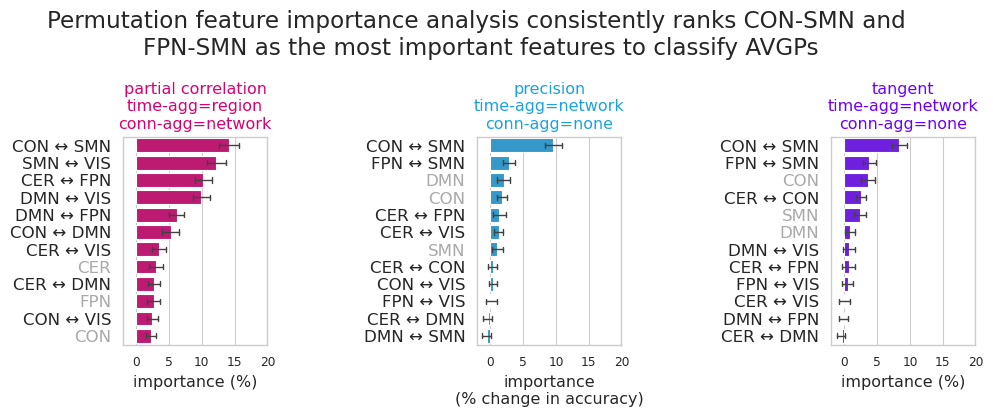

In [15]:

_, axes = plt.subplots(1,len(top_model_names),
                       gridspec_kw={'wspace': 1.45, 'hspace': .0},
                       figsize=(11,2.7), sharey=False, sharex=True, squeeze=True)

def plot_feature_importance(results, model_name, n_features=-1, color='black', ax=None):

    if f'{model_name}_importance' not in results.keys():
        print(f'{model_name}_importance does not have importance scores')
        return
    # extract the permutation importance scores
    perm_imp_scores = results[f'{model_name}_importance'].to_pandas() * 100.0
    perm_imp_scores.columns = perm_imp_scores.columns.to_series().apply(clean_network_labels)
    perm_imp_order = perm_imp_scores.mean().sort_values(ascending=False).index.to_list()
    perm_imp_order = perm_imp_order[:n_features]

    g = sns.barplot(data=perm_imp_scores,
                order=perm_imp_order,
                orient='h',
                capsize=.3,
                errwidth=1,
                color=color,
                ax=ax)

    g.set_yticklabels(g.get_yticklabels(), fontsize=12)
    g.set_xticks([0, 5, 10, 15, 20])
    g.set_ylabel('')
    g.set_xlabel('importance\n(% change in accuracy)', fontsize='large')
    ax.set_title(clean_model_label(model_name), fontsize='large', color=color, fontweight='normal')

    for tick in g.get_yticklabels():
        if '\N{left right arrow}' not in str(tick):
            tick.set_color('darkgray')

# iterate over top models and plot feature importance
for i, (model_name, ax) in enumerate(zip(top_model_names, axes.flatten())):
    plot_feature_importance(RESULTS, model_name,
                            color=MODEL_COLORS[top_model_names.index(model_name)],
                            ax=ax,
                            n_features=12)

# fix the x-axis labels
axes.flatten()[0].set_xlabel('importance (%)', fontsize='large')
axes.flatten()[2].set_xlabel('importance (%)', fontsize='large')

plt.suptitle('Permutation feature importance analysis consistently ranks CON-SMN and \n'
             'FPN-SMN as the most important features to classify AVGPs',
             fontsize='xx-large', x=.45, y=1.35)

plt.savefig(f'outputs/figures/fig3_feature_importance_{INPUT_NAME}.png', dpi=300, bbox_inches='tight')

In [5]:
raise Exception('skipping...')
def combine_feature_importances(results, n_features=-1, ax=None):

    model_names = results['model_name'].values.tolist()

    from IPython.display import display


    imp_scores_all = []

    for model_name in model_names:
        imp_scores = results[f'{model_name} importances'].to_pandas()
        imp_scores.columns.name = None

        # debug
        # imp_scores = imp_scores.head()

        atlas, kind = model_name.split(' ', 1)
        imp_scores['atlas'] = atlas
        imp_scores['kind'] = kind

        
        imp_scores = imp_scores.reset_index().melt(
            var_name='connectivity',
            id_vars=['permutation_importance_num', 'atlas', 'kind'])


        imp_scores_all.append(imp_scores)

    imp_scores_all = pd.concat(imp_scores_all)

    return imp_scores_all

    # for tick in g.get_yticklabels():
    #     if '\N{left right arrow}' not in str(tick):
    #         tick.set_color('darkgray')

combined_feature_importances = combine_feature_importances(RESULTS)
combined_feature_importances = combined_feature_importances.query('atlas != "seitzman2018"')

g = sns.FacetGrid(combined_feature_importances, col='kind', row='atlas',
                  height=2, aspect=2,
                  dropna=True,
                  xlim=(0, 0.2),
                  sharex=False, sharey=False, margin_titles=True)


def plot_model(**kwargs):
    data = kwargs.pop('data')
    n_features = kwargs.pop('n_features', 10)

    data = data.pivot(columns='connectivity', index='permutation_importance_num', values='value')
    order = data.mean().sort_values(ascending=False).index.to_list()
    order = order[:n_features]

    sns.barplot(data=data, order=order, orient='horizontal', **kwargs)

g.map_dataframe(plot_model, n_features=10)

for (i,j,k), data in g.facet_data():
    if j == 1:
        pass
        # g.facet_axis(i, j).set(yticklabels=[])
        # g.facet_axis(i, j).set_yticks([])
    if not data.empty:
        print(data['atlas'].unique()[0])
    else:
        ax = g.facet_axis(i, j)
        ax.set_axis_off()
        # ax.set_visible(False)

plt.tight_layout()

Exception: skipping...